In [ ]:
pip install python-bcb

   ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
   -------------------------------------- - 3.9/4.1 MB 36.6 MB/s eta 0:00:01
   ---------------------------------------- 4.1/4.1 MB 28.4 MB/s  0:00:00

   ---------------------------------------- 0/2 [lxml]
   ---------------------------------------- 0/2 [lxml]
   ---------------------------------------- 0/2 [lxml]
   ---------------------------------------- 2/2 [python-bcb]

Note: you may need to restart the kernel to use updated packages.


In [1]:
from bcb import sgs
import pandas as pd

In [2]:
df_bcb = sgs.get({'selic': 432, 'ipca': 433}, start='2016-01-01', end='2018-12-31')

In [3]:
print(df_bcb.head())

            selic  ipca
Date                   
2016-01-01  14.25  1.27
2016-01-02  14.25   NaN
2016-01-03  14.25   NaN
2016-01-04  14.25   NaN
2016-01-05  14.25   NaN


In [4]:
df_bcb.info(), df_bcb.index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2016-01-01 to 2018-12-31
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   selic   1096 non-null   float64
 1   ipca    36 non-null     float64
dtypes: float64(2)
memory usage: 25.7 KB


(None,
 DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
                '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
                '2016-01-09', '2016-01-10',
                ...
                '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
                '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
                '2018-12-30', '2018-12-31'],
               dtype='datetime64[ns]', name='Date', length=1096, freq='D'))

In [5]:
df_bcb['ipca'].isnull().any() 

np.True_

In [49]:
df_bcb.index = pd.to_datetime(df_bcb.index) # garantir que Index seja um datetime
df_bcb.index.name = 'Date'

In [50]:
df_bcb_mensal = df_bcb.resample('ME').agg({'selic': 'mean', 'ipca': 'last'}) 

In [51]:
df_bcb_mensal['selic_mensal'] = ((1 + (df_bcb_mensal['selic'] / 100))**(1/12) - 1) * 100
df_bcb_mensal['selic_mensal'] = df_bcb_mensal['selic_mensal'].round(2)
print(df_bcb_mensal.head(), df_bcb_mensal.tail())

            selic  ipca  selic_mensal
Date                                 
2016-01-31  14.25  1.27          1.12
2016-02-29  14.25  0.90          1.12
2016-03-31  14.25  0.43          1.12
2016-04-30  14.25  0.61          1.12
2016-05-31  14.25  0.78          1.12             selic  ipca  selic_mensal
Date                                 
2018-08-31    6.5 -0.09          0.53
2018-09-30    6.5  0.48          0.53
2018-10-31    6.5  0.45          0.53
2018-11-30    6.5 -0.21          0.53
2018-12-31    6.5  0.15          0.53


In [52]:
df_bcb_mensal = df_bcb_mensal.rename(columns={'ipca': 'ipca_mensal'})
print(df_bcb_mensal.columns)

Index(['selic', 'ipca_mensal', 'selic_mensal'], dtype='object')


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
PALETA_OLIST = ["#0047bb", "#94a3b8", "#1e293b", "#3b82f6", "#e2e8f0"]
sns.set_theme(style="whitegrid")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=PALETA_OLIST)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'

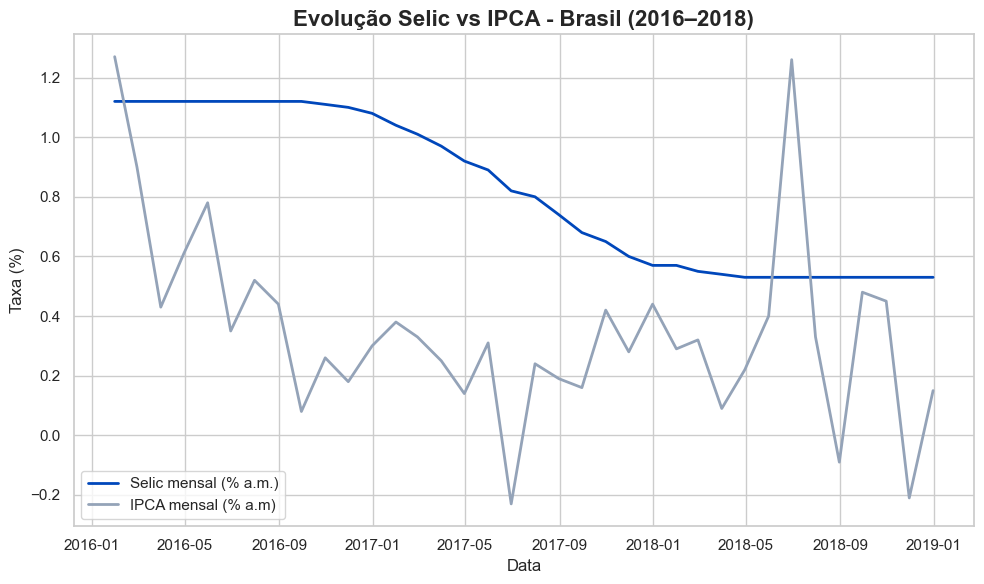

In [55]:
plt.plot(df_bcb_mensal.index, df_bcb_mensal['selic_mensal'], label='Selic mensal (% a.m.)', linewidth=2)
plt.plot(df_bcb_mensal.index, df_bcb_mensal['ipca_mensal'],  label='IPCA mensal (% a.m)', linewidth=2)

plt.title('Evolução Selic vs IPCA - Brasil (2016–2018)')
plt.xlabel('Data')
plt.ylabel('Taxa (%)')
plt.legend()
plt.tight_layout()
plt.savefig('imagens/comparativo_macro.png', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
lags = [0, 3, 6, 12, 18, 24]

correlacoes = {}
for lag in lags:
    # Selic(t) vs IPCA(t + lag)
    corr = df_bcb_mensal['selic_mensal'].corr(df_bcb_mensal['ipca_mensal'].shift(-lag))
    correlacoes[lag] = corr

corr_series = pd.Series(correlacoes)

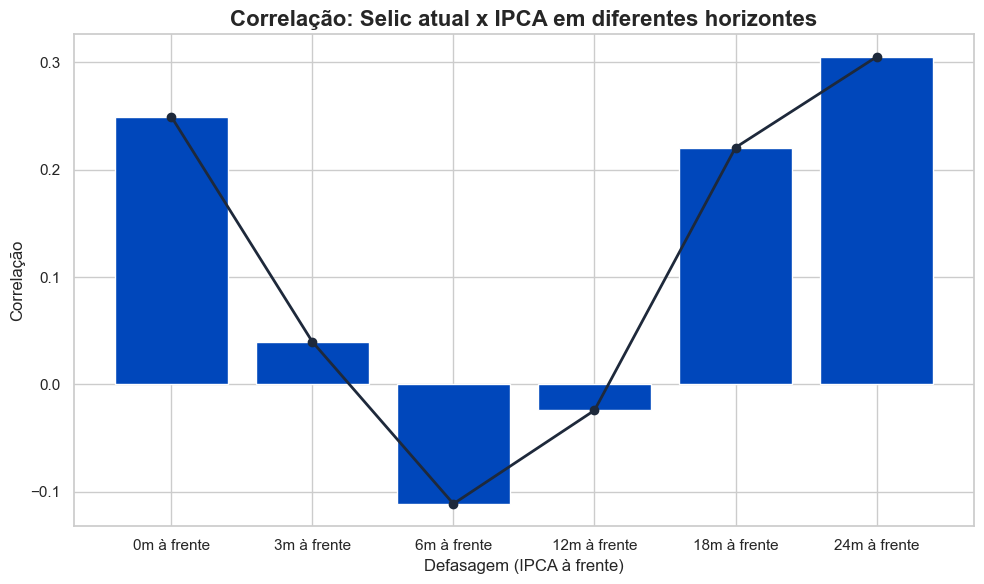

In [57]:
plt.bar(
    x=range(len(corr_series)),
    height=corr_series.values,
)

plt.plot(
    range(len(lags)),
    corr_series.values,
    color='#1e293b',
    marker='o',
    linewidth=2,
    label='Tendência'
)
plt.xticks(
    ticks=range(len(corr_series)),
    labels=[f'{lag}m à frente' for lag in corr_series.index]
)

plt.title('Correlação: Selic atual x IPCA em diferentes horizontes')
plt.xlabel('Defasagem (IPCA à frente)')
plt.ylabel('Correlação')
plt.tight_layout()
plt.savefig('imagens/correlacao_selic_ipca.png', dpi=300, bbox_inches='tight')
plt.show()

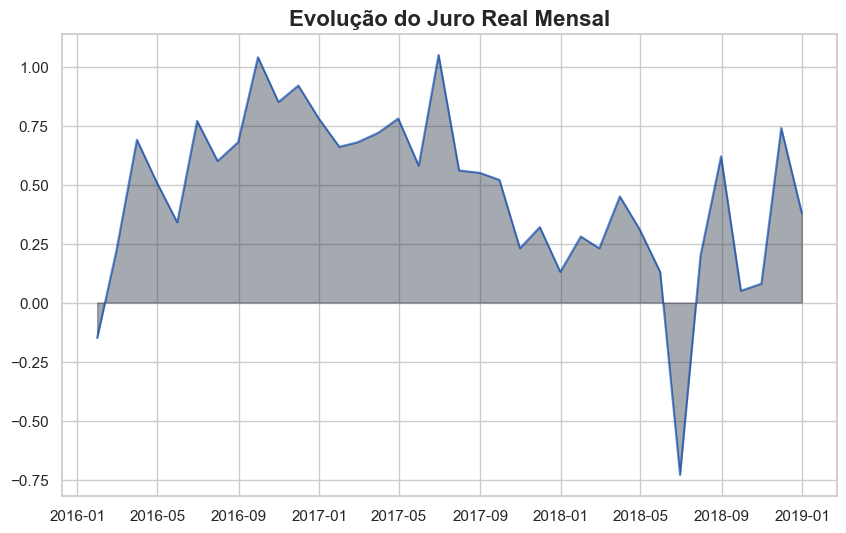

In [58]:
juro_real = df_bcb_mensal['selic_mensal'] - df_bcb_mensal['ipca_mensal']
plt.fill_between(df_bcb_mensal.index, juro_real, color="#1e293b", alpha=0.4)
plt.plot(df_bcb_mensal.index, juro_real, color="#0047bb", alpha=0.6)
plt.title('Evolução do Juro Real Mensal')

plt.savefig('imagens/juro_real_mensal.png', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
from sklearn.preprocessing import StandardScaler 

In [60]:
scaler = StandardScaler() # instanciar o escalonador

In [61]:
colunas = ['selic_mensal', 'ipca_mensal'] 

In [62]:
df_bcb_mensal[['selic_std', 'ipca_std']] = scaler.fit_transform(df_bcb_mensal[colunas]) # criando colunas com as variaveis padronizadas

In [63]:
print(df_bcb_mensal[['selic_std', 'ipca_std']].describe().round(2)) # confirmando a transformação com os valores das médias e desvios padrão

       selic_std  ipca_std
count      36.00     36.00
mean       -0.00      0.00
std         1.01      1.01
min        -1.14     -1.86
25%        -1.11     -0.53
50%        -0.04     -0.12
75%         1.16      0.28
max         1.19      2.92


In [64]:
df_bcb_mensal[['selic_std', 'ipca_std']] = df_bcb_mensal[['selic_std', 'ipca_std']].round(2)

In [65]:
df_bcb_mensal.head(10)

,selic,ipca_mensal,selic_mensal,selic_std,ipca_std
Date,,,,,
2016-01-31,14.250000,1.27,1.12,1.19,2.92
2016-02-29,14.250000,0.90,1.12,1.19,1.74
2016-03-31,14.250000,0.43,1.12,1.19,0.24
2016-04-30,14.250000,0.61,1.12,1.19,0.82
2016-05-31,14.250000,0.78,1.12,1.19,1.36
2016-06-30,14.250000,0.35,1.12,1.19,-0.01
2016-07-31,14.250000,0.52,1.12,1.19,0.53
2016-08-31,14.250000,0.44,1.12,1.19,0.28
2016-09-30,14.250000,0.08,1.12,1.19,-0.87


In [66]:
df_entrega = df_bcb_mensal.reset_index() # resetando o índice para que a data vire uma coluna comum

In [67]:
df_entrega.to_csv('analise_ipca_selic_processado.csv', index=False)